In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
pd.plotting.register_matplotlib_converters()
%matplotlib inline

#from fbprophet import Prophet

In [3]:
df_recent = pd.read_csv('../data/energy_recent_clean.csv', index_col = 'date')
df_past = pd.read_csv('../data/energy_past_clean.csv', index_col = 'date')

df_recent.set_index(pd.to_datetime(df_recent.index), inplace = True)
df_past.set_index(pd.to_datetime(df_past.index), inplace = True)

## Wind Power: [Source](https://en.wikipedia.org/wiki/Wind_power_in_the_United_States)

- Wind power is a rapidly growing industry that is now the largest component of the renewable energy sector, surpassing hydroelectric for the first time in 2019. 

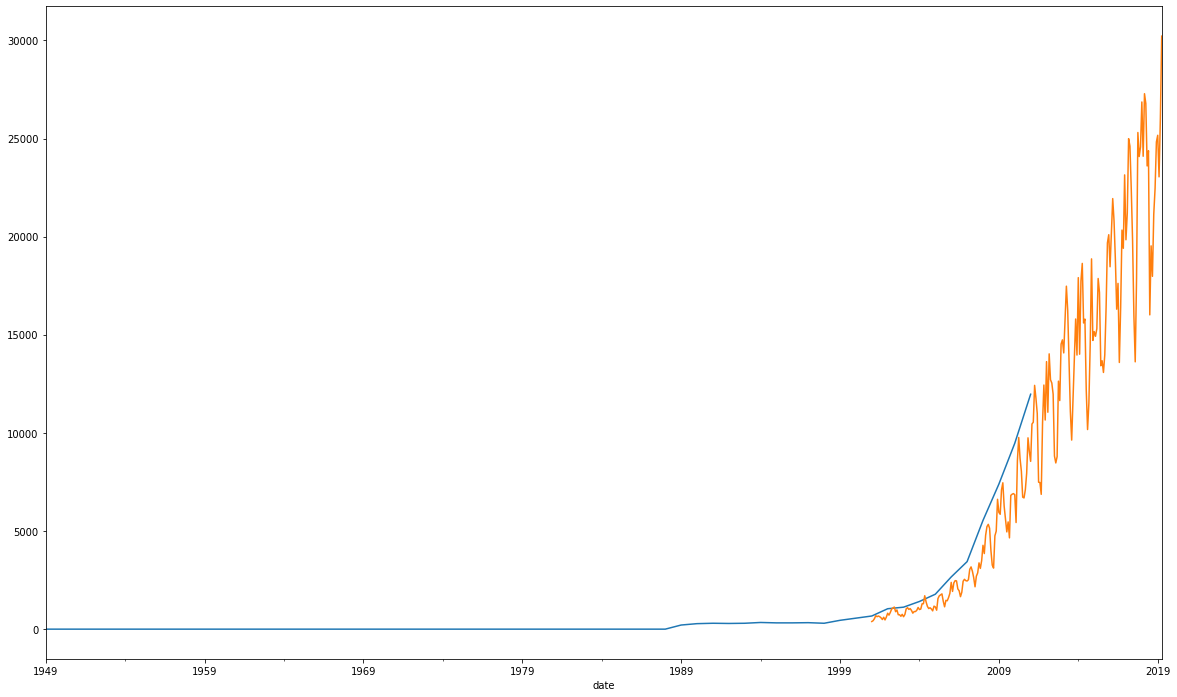

In [4]:
plt.figure(figsize = (20,12))
df_past['Wind'].plot()
df_recent['Wind'].plot()

#df_past['Total'].plot()
#df_recent['Total'].plot()

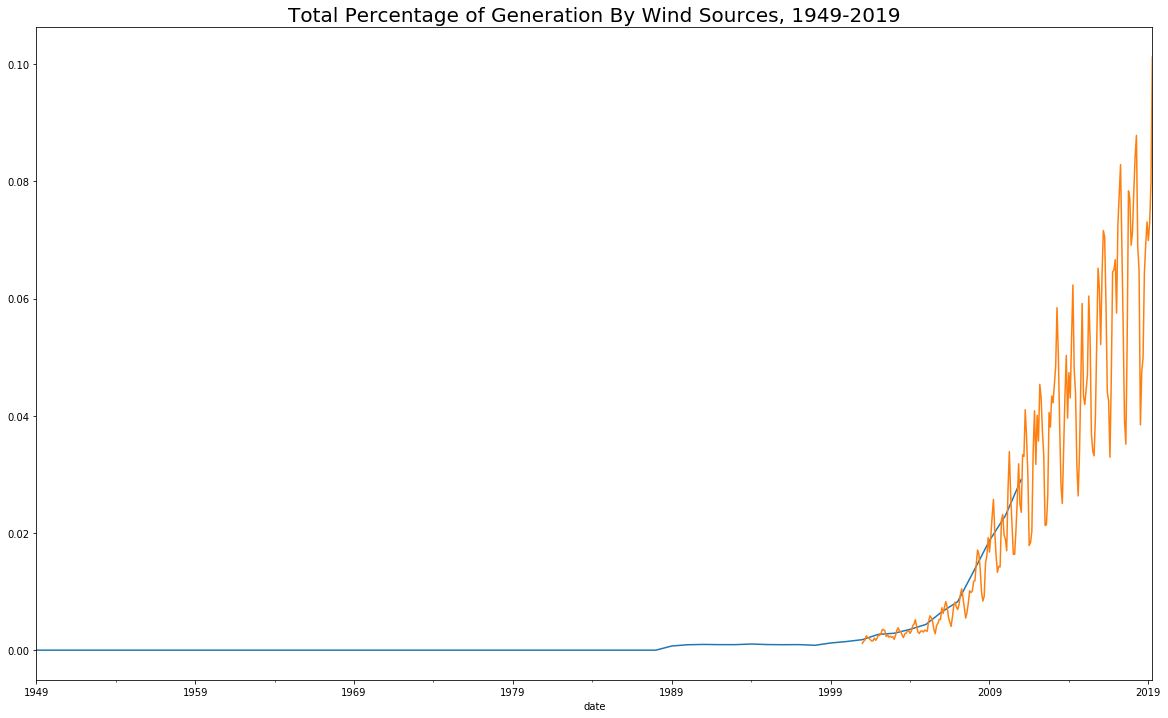

In [5]:
plt.figure(figsize = (20,12))
(df_past['Wind']/df_past['Total']).plot()
(df_recent['Wind']/df_recent['Total']).plot()
plt.title("Total Percentage of Generation By Wind Sources, 1949-2019", size = 20);

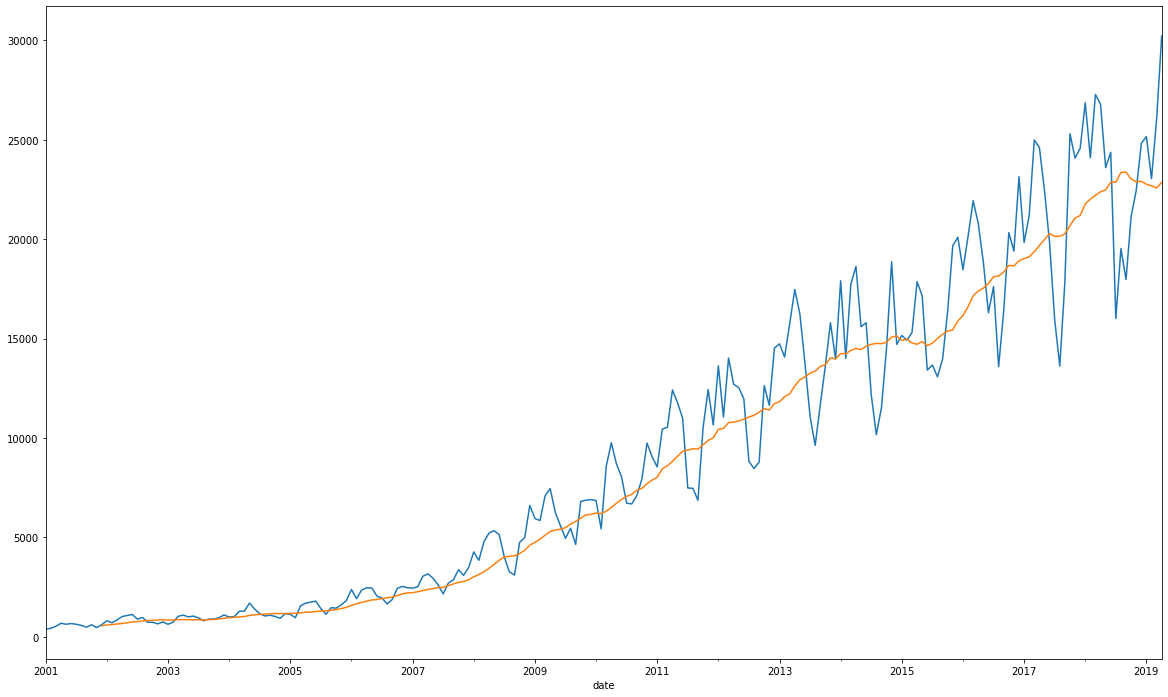

In [6]:
df_recent['Wind'].plot(figsize = (20,12))
df_recent['Wind'].rolling(12).mean().plot()

In [7]:
wind = pd.DataFrame(data = df_recent.index)
wind['y'] = list(df_recent['Wind'])
wind.rename(columns = {'date': 'ds'}, inplace = True)
wind['cap'] = 175_000
wind.head()

,ds,y,cap
0,2001-01-01,389.0,175000
1,2001-02-01,431.0,175000
2,2001-03-01,532.0,175000
3,2001-04-01,685.0,175000
4,2001-05-01,635.0,175000


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
train, test = train_test_split(wind, shuffle = False)
model_train = Prophet(growth = 'logistic', seasonality_mode= 'multiplicative')
model_train.fit(train)
train_future = model_train.make_future_dataframe(periods = test.shape[0], freq = 'M')
train_future['cap'] = 175_000
train_pred = model_train.predict(train_future)
np.sqrt(mean_squared_error(test['y'], train_pred['yhat'][-55:]))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5691.517791985315

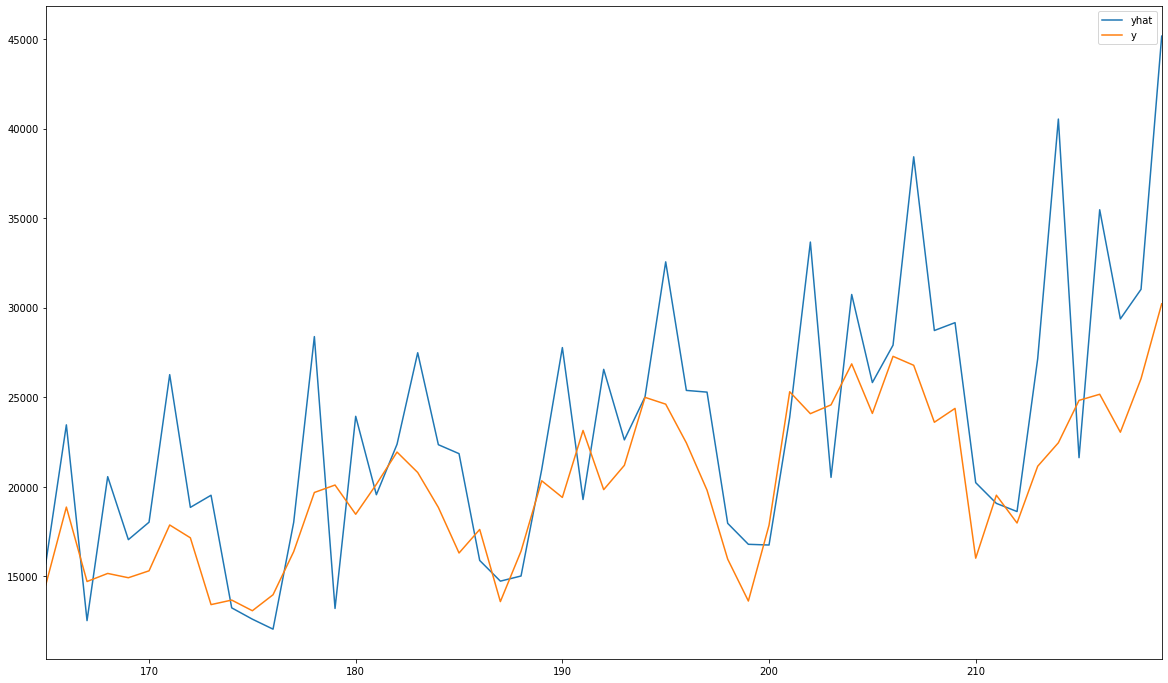

In [9]:
plt.figure(figsize = (20,12))
train_pred['yhat'][-55:].plot()
test['y'].plot()
plt.legend()

In [10]:
model_wind = Prophet(growth = 'logistic', seasonality_mode= 'multiplicative')
model_wind.fit(wind)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
wind_future = model_wind.make_future_dataframe(periods = 372, freq = 'M')
wind_future['cap'] = 175_000
wind_future.tail()

,ds,cap
587,2049-11-30,175000
588,2049-12-31,175000
589,2050-01-31,175000
590,2050-02-28,175000
591,2050-03-31,175000


In [12]:
wind_pred = model_wind.predict(wind_future)

In [13]:
df_recent['Total'].max() / 5

84474.8

In [14]:
wind_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
577,2049-01-31,156513.077239,127080.836442,171638.395562
578,2049-02-28,145960.482891,118632.728322,160067.761070
579,2049-03-31,184742.575143,150319.823509,202707.080304
580,2049-04-30,162814.188766,133062.059885,178374.399982
581,2049-05-31,150002.252450,122470.489605,164214.343774
582,2049-06-30,101400.218592,82754.718709,111016.257801
583,2049-07-31,123939.397695,101179.346975,135714.866504
584,2049-08-31,111937.217026,91040.236518,122587.822202
585,2049-09-30,128854.037161,104931.217700,140857.694825
586,2049-10-31,177418.860340,144773.147564,193423.979044


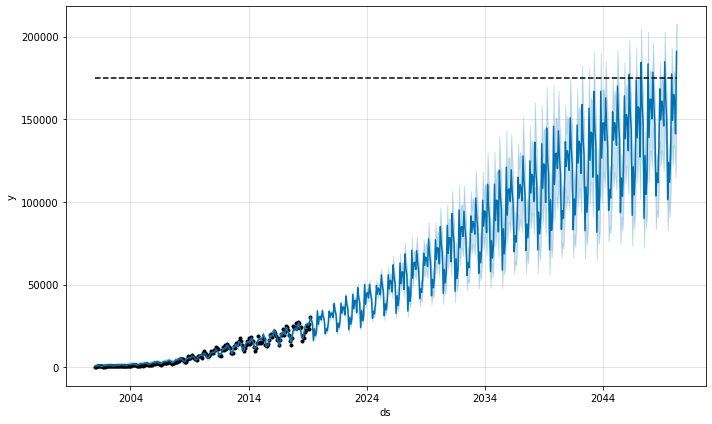

In [15]:
fig1 = model_wind.plot(wind_pred)

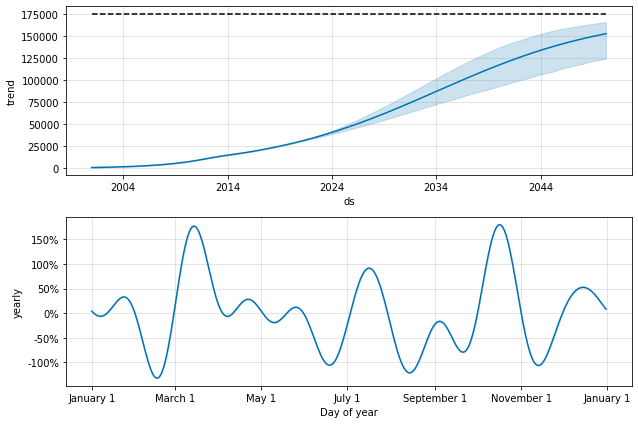

In [16]:
fig2 = model_wind.plot_components(wind_pred)

In [18]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(model_wind, wind_pred) # this returns a plotly figure
py.iplot(fig)

## Key takeaways

Wind is only going to become more important as the years go by, not less. At current projections it could very easily hit 20% of all electricity generation by 2030, which is a specific mark that the [US government would like to hit](https://www.energy.gov/eere/wind/20-wind-energy-2030-increasing-wind-energys-contribution-us-electricity-supply)

In [66]:
wind_pred.to_csv("../data/Predictions_Wind")

### Okay, let's try RNN

In [67]:
wind

,ds,y,cap
0,2001-01-01,389.0,175000
1,2001-02-01,431.0,175000
2,2001-03-01,532.0,175000
3,2001-04-01,685.0,175000
4,2001-05-01,635.0,175000
5,2001-06-01,670.0,175000
6,2001-07-01,635.0,175000
7,2001-08-01,577.0,175000
8,2001-09-01,490.0,175000
9,2001-10-01,607.0,175000


In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, LSTM
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator


Using TensorFlow backend.


In [69]:
wind.drop('cap', axis = 1, inplace = True)
wind.set_index('ds', inplace = True)
wind.head()

,y
ds,
2001-01-01,389.0
2001-02-01,431.0
2001-03-01,532.0
2001-04-01,685.0
2001-05-01,635.0


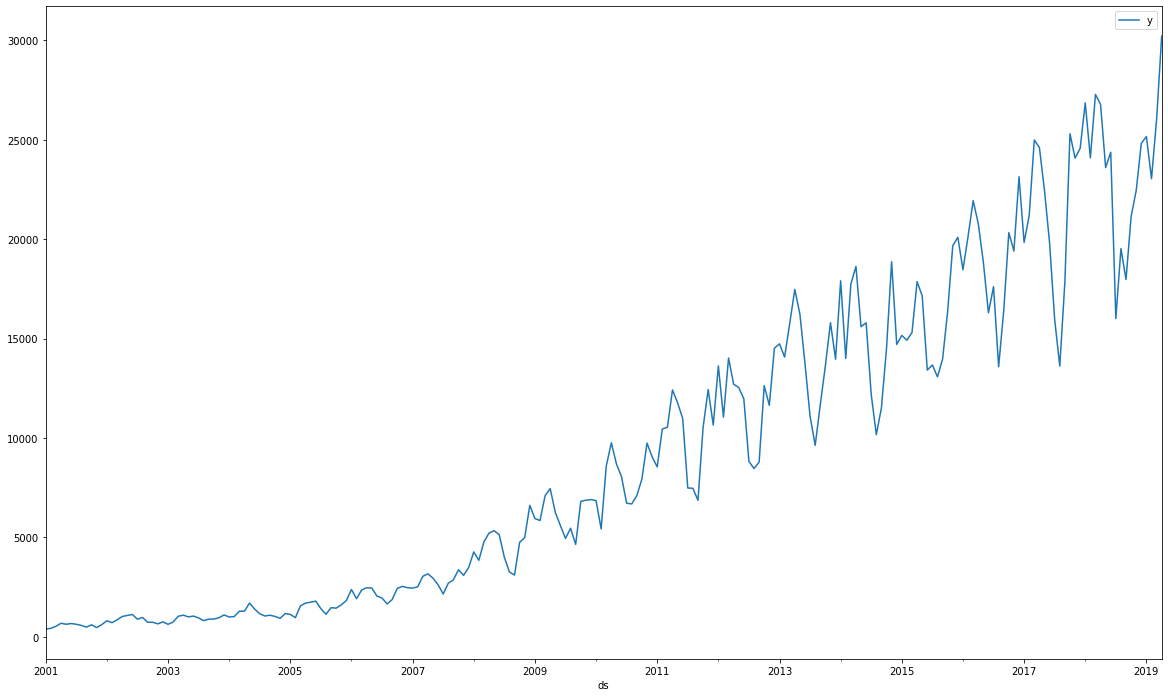

In [70]:
wind.plot(figsize = (20,12))

In [71]:
# wind = wind.pct_change()
# wind.tail()

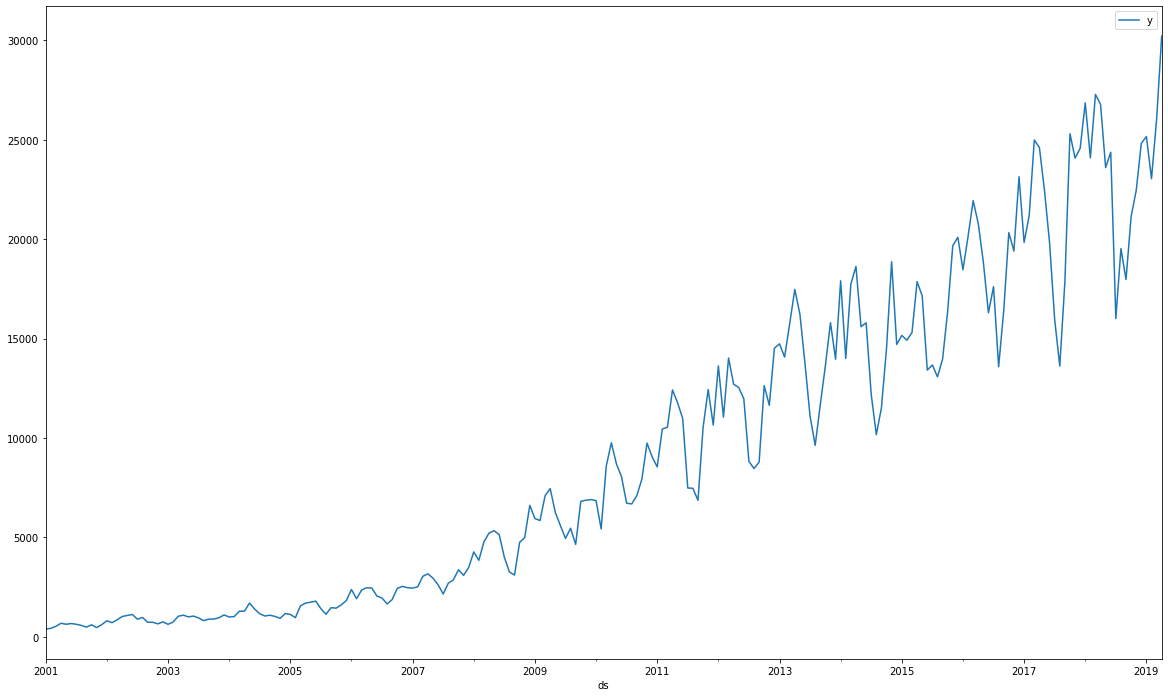

In [72]:
wind.plot(figsize = (20,12))

In [73]:
wind.head()

,y
ds,
2001-01-01,389.0
2001-02-01,431.0
2001-03-01,532.0
2001-04-01,685.0
2001-05-01,635.0


In [74]:
X = np.array(wind.index).reshape(-1,1)

y = np.array(wind['y']).reshape(-1,1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle = False, test_size = 0.25, random_state = 42)

In [76]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

C:\Users\NICK\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype datetime64[ns] was converted to float64 by StandardScaler.

C:\Users\NICK\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype datetime64[ns] was converted to float64 by StandardScaler.

C:\Users\NICK\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype datetime64[ns] was converted to float64 by StandardScaler.



In [77]:
train_generator = TimeseriesGenerator(X_train_ss, y_train, length = 12, batch_size = 1)
test_generator = TimeseriesGenerator(X_test_ss, y_test, length = 12, batch_size = 1)

In [ ]:
drop_rate = 0.4
model = Sequential()
model.add(LSTM(32, return_sequences = True, dropout = drop_rate, recurrent_dropout = drop_rate, input_shape = (12,1)))
model.add(LSTM(32, return_sequences = False, dropout = drop_rate, recurrent_dropout = drop_rate))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(rate = drop_rate))
# model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(rate = drop_rate))
# model.add(Dense(16, activation = 'relu'))
# model.add(Dropout(rate = drop_rate))
# model.add(Dense(16, activation = 'relu'))
# model.add(Dropout(rate = drop_rate))
# model.add(Dense(16, activation = 'relu'))
# model.add(Dropout(rate = drop_rate))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.025))
history = model.fit_generator(train_generator, epochs = 10, validation_data = test_generator, verbose = 1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


Epoch 1/500
153/153 [==============================] - 7s 48ms/step - loss: 49182913.2840 - val_loss: 345747472.7442
Epoch 2/500
153/153 [==============================] - 3s 23ms/step - loss: 28396854.3797 - val_loss: 284978810.9767
Epoch 3/500
153/153 [==============================] - 4s 27ms/step - loss: 21657447.0847 - val_loss: 191545741.3488
Epoch 4/500
153/153 [==============================] - 4s 25ms/step - loss: 11685166.8352 - val_loss: 160544931.6279
Epoch 5/500
153/153 [==============================] - 4s 25ms/step - loss: 11165872.2666 - val_loss: 105970735.9128
Epoch 6/500
153/153 [==============================] - 4s 27ms/step - loss: 10307263.7629 - val_loss: 123951998.8140
Epoch 7/500
153/153 [==============================] - 4s 24ms/step - loss: 11283445.8838 - val_loss: 117141210.8953
Epoch 8/500
153/153 [==============================] - 4s 24ms/step - loss: 9053767.5433 - val_loss: 81515937.3459
Epoch 9/500
153/153 [==============================] - 4s 24ms/ste

In [ ]:
plt.figure(figsize = (20,12))
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = "Test")
plt.legend()

In [ ]:
pred_train = model.predict_generator(train_generator)

plt.figure(figsize = (20,12))
plt.plot(pred_train, label = 'Prediction')
plt.plot(y_train, label = 'Actual')
plt.legend()

In [ ]:
pred_test = model.predict_generator(test_generator)

plt.figure(figsize = (20,12))
plt.plot(pred_test, label = 'Prediction')
plt.plot(y_test, label = 'Actual')



## Hmm

...Yeah points for trying, but I think I'll stick with Facebook Prophet. 